In [1]:
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt

# A Gaussian conditional distribution from a small Bayesian network

In lecture, a small Gaussian Bayesian network is defined with four variables. The code below simulates $N$ realizations from the network by using the four update equations. The implementation is vectorized over the $N$ replications.

Note that since Python uses zero-based indexing it is convenient to denote the variables as $X_0, X_1, X_2, X_3$ to avoid confusion.

In [2]:
N = 10000
x = np.zeros(shape=(N, 4))
z = np.random.normal(size=(N, 4))
x[:, 0] = z[:, 0]
x[:, 1] = 0.5 * z[:, 1]
x[:, 2] = x[:, 0] + 4 * z[:, 2]
x[:, 3] = x[:, 1] + 3 * x[:, 2] + 0.3 * z[:, 3]

In [ ]:
x.shape

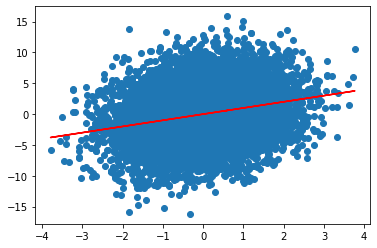

In [3]:
plt.scatter(x[:, 0], x[:, 2])
plt.plot(x[:, 0], x[:, 0], 'r')

The plot of $x_2$ against $x_0$ illustrates that in the update equation 
$$X_2 = X_0 + 4 Z_2$$
the variable $X_2$ is a linear function of $X_0$ with slope 1 and some independent noise. If we do a linear regression of $x_2$ against $x_0$ we recover that slope parameter (and the intercept being 0). 

In [4]:
# The slope and intercept parameters from a linear regression
stats.linregress(x[:, 0], x[:, 2])[0:2]

(0.9233545587930951, -0.03550345451047229)

If we flip the perspective around and plot $x_0$ against $x_2$ we cannot directly extract the corresponding linear regression out of the equations defining the network. A naive solution to just "solve the equations involving the two variables" is wrong, because the noise, $4Z_2$, and $X_2$ are *dependent*. 

In [ ]:
plt.scatter(x[:, 2], x[:, 0])
# Wrong (naive) regression line from update equations, dashed on plot
plt.plot(x[:, 2], x[:, 2], 'r:')
# Correct regression line from conditional distribution
plt.plot(x[:, 2], x[:, 2] / 17, 'y')

If we do the linear regression, we should compare the slope to $1/17 \simeq 0.0588$.

In [ ]:
stats.linregress(x[:, 2], x[:, 0])[0:2]

We can also estimate the residual variance, which should be compared to $16/17 \simeq 0.9412$

In [ ]:
sum((x[:, 0] -  x[:, 2] / 17) ** 2) / N

# The autoregressive process

The autoregressive process has the update equation
$$X_i = \alpha X_{i-1} + Z_i$$
where $Z_1, \ldots, Z_n$ are independent, and for this example $\mathcal{N}(0, 1)$-distributed. We also take $X_0 \sim \mathcal{N}(0,1)$. We first implement a function that can simulate from this model for arbitrary parameter $\alpha \in \mathbb{R}$ and $n$. For convenience in later use, it simulates $N$ replications in a vectorized manner.

In [5]:
def auto_sim(alpha = 0, n = 100, N = 1):
    x = np.zeros(shape = (N, n + 1))
    z = np.random.normal(size = (N, n + 1))
    x[:, 0] = z[:, 0]
    for i in range(1, n + 1):
        x[:, i] = alpha * x[:, i - 1] + z[:, i]
    return(x)

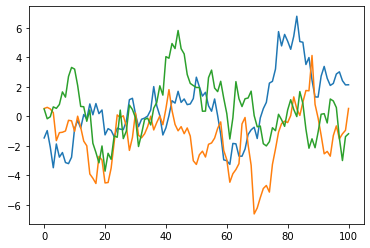

In [6]:
# plot of three examples
x1 = auto_sim(alpha = 0.9, N = 3)
plt.plot(x1[0,:])
plt.plot(x1[1,:])
plt.plot(x1[2,:])

The function below creates the information matrix $J$ for the joint distribution. It is a so-called band diagonal matrix with non-zero entries only in the diagonal and just above and just below the diagonal. The implementation below using a dense matrix is wasteful in terms of memory but the subsequent variable elimination is still efficient in terms of run time. An optimized implementation will avoid storing all the zeroes of the matrix $J$ and thus be memory efficient as well.

In [7]:
def J_mat(alpha = 0, n = 100):
    J = np.zeros(shape = (n + 1, n + 1))
    J[0, 0] = 1 + alpha ** 2
    J[0, 1] = - alpha
    J[n, n] = 1
    J[n, n - 1] = - alpha
    for i in range(1, n):
        J[i, i] = 1 + alpha ** 2
        J[i, i - 1] = - alpha
        J[i, i + 1] = - alpha
    return(J)

In [8]:
 J_mat(alpha = 0.9, n = 5)  # Note the band diagonal structure.

array([[ 1.81, -0.9 ,  0.  ,  0.  ,  0.  ,  0.  ],
       [-0.9 ,  1.81, -0.9 ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -0.9 ,  1.81, -0.9 ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -0.9 ,  1.81, -0.9 ,  0.  ],
       [ 0.  ,  0.  ,  0.  , -0.9 ,  1.81, -0.9 ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.9 ,  1.  ]])

We implement variable elimination as described on slide 11, Friday 5/3, 2021. The function eliminates all variables but the first and returns the mean and variance. If called with an appropriate $h$-vector it computes the conditional mean and conditional variance of $X_0$ given $X_n = x_n$, say. Note how the zero entries of $J$ never become non-zero, and that the algorithm is linear in $n$.

In [9]:
def sum_prod_VE(J, h):
    n = len(h)
    J = J.copy()
    h = h.copy()
    for i in reversed(range(1, n)):
        J[i - 1, i - 1] -= J[i - 1, i] * J[i, i - 1] / J[i, i]
        h[i - 1] -= h[i] * J[i - 1, i] / J[i, i]
    return((h[0] / J[0, 0], 1 / J[0, 0]))

The following shows how variable elimination is used for computing the conditional distribution of $X_0$ given $X_n$ for $n = 10$ and $\alpha = 0.99$.

In [10]:
n = 10
alpha = 0.99
xn = 1  # Evidence set to 1 will give slope of conditional distribution as intercept is known to be 0 in this example
J = J_mat(alpha = alpha, n = n)
h = np.zeros(shape = n)
h[n - 1] = alpha * xn  # Updating the last entry of h corresponding to the conditioning operation
sum_prod_VE(J[0:n], h[0:n]) # The slope and conditional variance of X_0 | X_n

(0.090725698336527, 0.9179493046817891)

Now we could instead compute the inverse of $J$,
$$\Sigma = J^{-1},$$
marginalize to the covariance matrix for $\{X_0, X_n\}$,  $\Sigma_{\{0,n\}, \{0,n\}}$, and compute the conditional distribution of $X_0 \mid X_n$ using the formulas from Theorem 7.4 (slide 15, Tuesday 2/3, 2021).

In [ ]:
Sigma = np.linalg.inv(J)[0:(n+1):n, 0:(n+1):n] # The 2 x 2 covariance matrix of X_0, X_n

In [ ]:
(Sigma[0,1] / Sigma[1, 1], Sigma[0, 0] - Sigma[0, 1] * Sigma[1, 0] / Sigma[1, 1]) # slope and conditional variance, same as VE above!

We can again illustrate these computations in terms of linear regressions, where we simulate a large number, $N$, of data vectors from the Bayesian network, and then we do a linear regression of $x_0$ on $x_n$ to find the conditional distribution.

In [ ]:
N = 100000
xx = auto_sim(alpha = alpha, n = n, N = N)
stats.linregress(xx[:, n], xx[:, 0])[0:2]  # Slope and intercept, with intercept essentially 0

In [ ]:
beta = stats.linregress(xx[:, n], xx[:, 0])[0]
plt.scatter(xx[:, n], xx[:, 0])
plt.plot(xx[:, n], beta * xx[:, n], 'r') 

In [ ]:
sum((xx[:, 0] -  beta * xx[:, n]) ** 2) / N  # (Conditional) variance estimate. Compare to the one computed above